In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Specify each path

In [2]:
data_directory = "../../../data/"
train_dataset = f'{data_directory}augmented_gestures_train.csv'
test_dataset = f'{data_directory}augmented_gestures_test.csv'
model_save_path = './gesture_classifier.keras'
tflite_save_path = './gesture_classifier.tflite'

# Set number of classes

In [3]:
RANDOM_SEED = 42
NUM_CLASSES = 5
NUM_SEQUENCE_FRAMES = 10
MULTI_HAND_LANDMARKS = 126
FEATURE_DIM = MULTI_HAND_LANDMARKS * NUM_SEQUENCE_FRAMES

# Dataset reading

In [4]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, FEATURE_DIM + 1)))
X_test_data = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, FEATURE_DIM + 1)))

In [5]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test_data = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_data, y_test_data, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_valid))

[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]


In [8]:
print(X_train.shape)
print(y_train.shape)

(551, 1260)
(551,)


# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((FEATURE_DIM, )),
    # tf.keras.layers.BatchNormalization(),  # Normalizes input features
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer with 5 units
])

In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


1/5 [=====>........................] - ETA: 3s - loss: 5.5453 - accuracy: 0.1641
Epoch 1: saving model to .\gesture_classifier.keras
5/5 [==============================] - 1s 66ms/step - loss: 2.7275 - accuracy: 0.4555 - val_loss: 0.6910 - val_accuracy: 0.6145
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.8273 - accuracy: 0.7578
Epoch 2: saving model to .\gesture_classifier.keras
5/5 [==============================] - 0s 20ms/step - loss: 0.6586 - accuracy: 0.8185 - val_loss: 0.5977 - val_accuracy: 0.6145
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.4664 - accuracy: 0.8359
Epoch 3: saving model to .\gesture_classifier.keras
5/5 [==============================] - 0s 19ms/step - loss: 0.3881 - accuracy: 0.8748 - val_loss: 0.4571 - val_accuracy: 0.8193
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.2979 - accuracy: 0.8984
Epoch 4: saving model to .\gesture_classifier.keras
5/5 [=========================

In [14]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 0.3980 - accuracy: 0.9717


In [15]:
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(y_test[0])

1/1 [==============================] - 0s 85ms/step
[5.6423342e-01 1.8590833e-03 3.2266413e-05 4.5423285e-04 4.3342093e-01]
0
0


# Confusion matrix

8/8 [==============================] - 0s 2ms/step


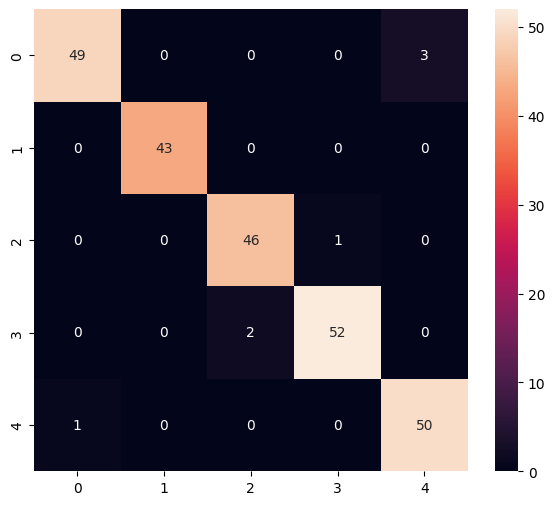

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       1.00      1.00      1.00        43
           2       0.96      0.98      0.97        47
           3       0.98      0.96      0.97        54
           4       0.94      0.98      0.96        51

    accuracy                           0.97       247
   macro avg       0.97      0.97      0.97       247
weighted avg       0.97      0.97      0.97       247



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [19]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpwcrwrlsy\assets


INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpwcrwrlsy\assets


369272

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1. 0. 0. 0. 0.]
0
CPU times: total: 0 ns
Wall time: 999 µs
